**Problem 3.2: Basic LangChain Agent with Tools**  
**Goal:** Create an agent that can use a simple tool.

**Task:**  
- Create a custom LangChain Tool to calculate the square of a number.  
- Name and describe the tool clearly.  
- Initialize an agent (e.g., `create_openai_functions_agent` or `create_react_agent`) with:  
  - an LLM  
  - your custom tool  
- Create an `AgentExecutor` for the agent.  
- Ask questions like:  
  - "What is the square of 5?"  
  - "If I have 7 apples and multiply that by itself, how many do I have?"

**LangChain Concepts:**  
`@tool` or `Tool`, `create_openai_functions_agent`, `AgentExecutor`, agent prompting

**Verification:**  
- Does the agent correctly identify when to use the tool?  
- Does it return the correct squared number?  
- If ReAct agent is used, observe its "thought" steps.


In [13]:
from dotenv import load_dotenv

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage

from typing import List,Optional, TypedDict, Sequence, Annotated, Any

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph,START,END

In [14]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

from langchain.embeddings import HuggingFaceBgeEmbeddings

In [15]:
load_dotenv()

True

In [16]:
## state definition

class AgentState(TypedDict):
    message : Optional[List[str]]
    classification : str

In [17]:
# ---- Model Binding ----
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest", temperature=0.7
)

In [18]:
def classify_intent(state: AgentState) -> AgentState:
    """
        divides this into a classifier
    """
    sys_prompt = SystemMessage(content="you are a classifier based on the context classify these into one of the classes ['greeting' ,'question' , 'other'] ")
    
    msg = input("enter prompt: ")
    state["message"] = msg
    prompt = HumanMessage(content=msg)
    
    resp = llm.invoke([sys_prompt , prompt])
    state["classification"] = resp.content
    print(resp.content)
    return state

In [19]:
def route(state: AgentState) -> str:
    return state["classification"]


In [20]:
def handle_greeting(state: AgentState) -> AgentState:

    """
        respond as a greeter
    """
    sys_prompt = SystemMessage(content="you are a greeter, politely greet the user based on his context ")
    
    msg = state["message"]
    prompt = HumanMessage(content=msg)
    
    resp = llm.invoke([sys_prompt , prompt])
    print(resp.content)
    return state

In [21]:
def handle_question(state: AgentState) -> AgentState:

    """
        respond as a q/a bot
    """
    sys_prompt = SystemMessage(content="you are a question answering chat bot. answer the user question clearly and precisely no hallucinations")
    
    msg = state["message"]
    prompt = HumanMessage(content=msg)
    
    resp = llm.invoke([sys_prompt , prompt])
    print(resp.content)
    return state

In [22]:
graph = StateGraph(AgentState)

graph.add_node("classifier", classify_intent)
graph.add_node("q", handle_question)
graph.add_node("g", handle_greeting)

graph.add_conditional_edges(
    "classifier",
    route,
    {
        "greeting": "g",
        "question": "q",
        "other": END
    }
)

graph.add_edge(START,"classifier")
graph.add_edge("q", END)
graph.add_edge("g", END)

app = graph.compile()

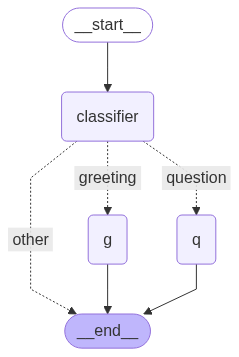

In [23]:
from IPython.display import Image, display
from io import BytesIO

# Get image bytes directly from your graph generator
image_bytes = app.get_graph().draw_mermaid_png()

# Display the image without saving
display(Image(data=image_bytes))


In [24]:
## run agent
state = {
    "message" : [],
    "classification" : ""
}
result = app.invoke(state)
# print(result["classification"])

greeting
Hi there! I'm doing well, thank you for asking. How can I help you today?
